# Robyn: Marketing Mix Modeling Application

This notebook demonstrates the usage of Robyn, a Marketing Mix Modeling (MMM) application. 
We'll go through the main steps of performing robyn_inputs and robyn_engineering.



## 1. Import Required Libraries. Define Paths.

First, be sure to setup your virtual environment. Be sure to switch over to your new environment in this notebook. 

-```cd {root_folder}```

-```python3 -m yourvenv```

-```source yourvenv/bin/activate```

-```cd Robyn/python```

-```pip install -r requirements.txt```


Then import the necessary libraries. Make sure to define your paths below.



In [1]:
import sys

# Add Robyn to path
sys.path.append("/Users/yijuilee/robynpy_release_reviews/Robyn/python/src")

In [2]:
import pandas as pd
from robyn.data.entities.mmmdata import MMMData
from robyn.data.entities.enums import AdstockType
from robyn.data.entities.holidays_data import HolidaysData
from robyn.data.entities.hyperparameters import Hyperparameters, ChannelHyperparameters
from robyn.modeling.entities.modelrun_trials_config import TrialsConfig
from robyn.modeling.model_executor import ModelExecutor
from robyn.modeling.entities.enums import NevergradAlgorithm, Models
from robyn.modeling.feature_engineering import FeatureEngineering

2024-11-14 16:32:15,775 - robyn - INFO - Logging is set up to console only.
/Users/yijuilee/robynpy_release_reviews/robynvenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2.1 Load Mock R data

We need to set the base path for the data directory.
Create a .env file in the same directory as your notebook and put in define the path to the data dir.
for example: ROBYN_BASE_PATH=.../Robyn/R/data

In [3]:
# Read the simulated data and holidays data
dt_simulated_weekly = pd.read_csv("resources/dt_simulated_weekly.csv")

dt_prophet_holidays = pd.read_csv("resources/dt_prophet_holidays.csv")

## Setup MMM Data

We will now set up the MMM data specification which includes defining the dependent variable, independent variables, and the time window for analysis.

In [4]:
def setup_mmm_data(dt_simulated_weekly) -> MMMData:

    mmm_data_spec = MMMData.MMMDataSpec(
        dep_var="revenue",
        dep_var_type="revenue",
        date_var="DATE",
        context_vars=["competitor_sales_B", "events"],
        paid_media_spends=["tv_S", "ooh_S", "print_S", "facebook_S", "search_S"],
        paid_media_vars=["tv_S", "ooh_S", "print_S", "facebook_I", "search_clicks_P"],
        organic_vars=["newsletter"],
        window_start="2016-01-01",
        window_end="2018-12-31",
    )

    return MMMData(data=dt_simulated_weekly, mmmdata_spec=mmm_data_spec)


mmm_data = setup_mmm_data(dt_simulated_weekly)
mmm_data.data.head()

,DATE,revenue,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter
0,2015-11-23,2.754372e+06,22358.346667,0.0,12728.488889,2.430128e+07,0.000000,0.000000,8125009,7607.132915,na,19401.653846
1,2015-11-30,2.584277e+06,28613.453333,0.0,0.000000,5.527033e+06,9837.238486,4133.333333,7901549,1141.952450,na,14791.000000
2,2015-12-07,2.547387e+06,0.000000,132278.4,453.866667,1.665159e+07,12044.119653,3786.666667,8300197,4256.375378,na,14544.000000
3,2015-12-14,2.875220e+06,83450.306667,0.0,17680.000000,1.054977e+07,12268.070319,4253.333333,8122883,2800.490677,na,2800.000000
4,2015-12-21,2.215953e+06,0.000000,277336.0,0.000000,2.934090e+06,9467.248023,3613.333333,7105985,689.582605,na,15478.000000


## Feature Preprocessing

We will perform feature engineering to prepare the data for modeling. This includes transformations like adstock and other preprocessing steps.

In [5]:
hyperparameters = Hyperparameters(
    {
        "facebook_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0, 0.3],
        ),
        "print_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
        "tv_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.3, 0.8],
        ),
        "search_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0, 0.3],
        ),
        "ooh_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
        "newsletter": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
    },
    adstock=AdstockType.GEOMETRIC,
    lambda_=[0, 1],
    train_size=[0.5, 0.8],
)

print("Hyperparameters setup complete.")

Hyperparameters setup complete.


In [6]:
# Create HolidaysData object
holidays_data = HolidaysData(
    dt_holidays=dt_prophet_holidays,
    prophet_vars=["trend", "season", "holiday"],
    prophet_country="DE",
    prophet_signs=["default", "default", "default"],
)
# Setup FeaturizedMMMData
feature_engineering = FeatureEngineering(mmm_data, hyperparameters, holidays_data)

In [7]:
featurized_mmm_data = feature_engineering.perform_feature_engineering()

2024-11-14 16:32:17,379 - robyn.modeling.feature_engineering - INFO - Starting feature engineering process
2024-11-14 16:32:17,382 - robyn.modeling.feature_engineering - INFO - Starting Prophet decomposition
2024-11-14 16:32:17,382 - robyn.modeling.feature_engineering - INFO - Starting Prophet decomposition
/Users/yijuilee/robynpy_release_reviews/robynvenv/lib/python3.9/site-packages/prophet/forecaster.py:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
2024-11-14 16:32:17,979 - cmdstanpy - DEBUG - input tempfile: /var/folders/gm/g5cpl7110m96nfd1qr1xwnwc0000gn/T/tmpw_z5mz9a/jjjbph2x.json
2024-11-14 16:32:17,988 - cmdstanpy - DEBUG - input tempfile: /var/folders/gm/g5cpl7110m96nfd1qr1xwnw

2024-11-14 16:32:18,178 - robyn.visualization.feature_visualization - INFO - Initializing FeaturePlotter
2024-11-14 16:32:18,178 - robyn.visualization.feature_visualization - INFO - Generating spend-exposure plot for channel: facebook_I
2024-11-14 16:32:18,345 - robyn.visualization.feature_visualization - INFO - Successfully generated spend-exposure plot for channel facebook_I


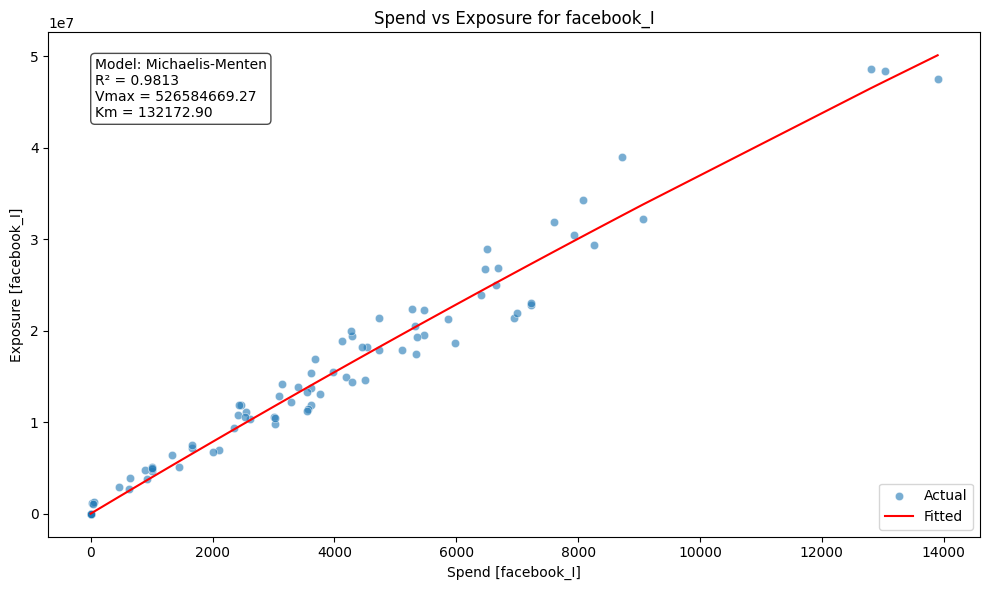

2024-11-14 16:32:18,450 - robyn.visualization.feature_visualization - INFO - Generating spend-exposure plot for channel: search_clicks_P
2024-11-14 16:32:18,612 - robyn.visualization.feature_visualization - INFO - Successfully generated spend-exposure plot for channel search_clicks_P


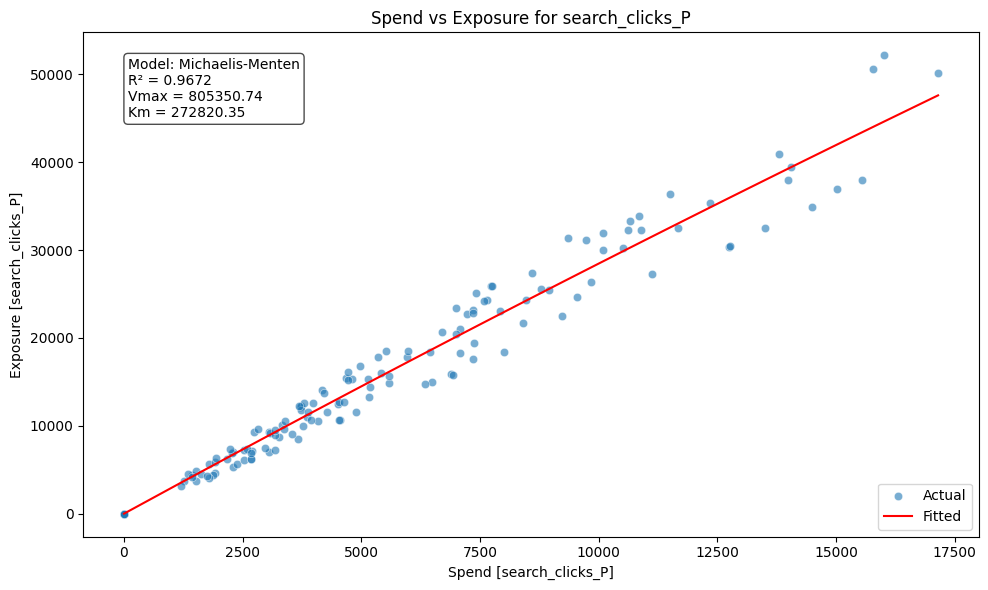

In [8]:
from robyn.visualization.feature_visualization import FeaturePlotter
import matplotlib.pyplot as plt
%matplotlib inline

# Create a FeaturePlotter instance
feature_plotter = FeaturePlotter(mmm_data, hyperparameters)
# Extract the list of results
results_list = featurized_mmm_data.modNLS["results"]
# Plot spend-exposure relationship for each channel in the results
for result in results_list:
    channel = result["channel"]
    try:
        fig = feature_plotter.plot_spend_exposure(featurized_mmm_data, channel)
        plt.show()
    except ValueError as e:
        print(f"Skipping {channel}: {str(e)}")

2024-11-14 16:32:18,703 - robyn.modeling.base_model_executor - INFO - Initializing BaseModelExecutor
2024-11-14 16:32:18,704 - robyn.modeling.model_executor - INFO - Starting model execution with model_name=Models.RIDGE
2024-11-14 16:32:18,704 - robyn.modeling.base_model_executor - INFO - Input validation successful
2024-11-14 16:32:18,705 - robyn.modeling.base_model_executor - INFO - Preparing hyperparameters
2024-11-14 16:32:18,705 - robyn.modeling.base_model_executor - INFO - Completed hyperparameter preparation with 20 parameters to optimize
2024-11-14 16:32:18,705 - robyn.modeling.model_executor - INFO - Initializing Ridge model builder
2024-11-14 16:32:18,706 - robyn.modeling.model_executor - INFO - Building models with configured parameters
2024-11-14 16:32:18,706 - robyn.modeling.ridge_model_builder - INFO - Collecting hyperparameters for optimization...


>>> Starting 5 trials with 2000 iterations each using TwoPointsDE nevergrad algorithm on...


Running trial 1 of total 5 trials: 100%|███████████████████████████████████
2024-11-14 16:35:27,567 - robyn.modeling.ridge_model_builder - INFO -  Finished in 3.15 mins
Running trial 2 of total 5 trials: 100%|███████████████████████████████████
2024-11-14 16:38:40,894 - robyn.modeling.ridge_model_builder - INFO -  Finished in 3.21 mins
Running trial 3 of total 5 trials: 100%|███████████████████████████████████
2024-11-14 16:42:02,362 - robyn.modeling.ridge_model_builder - INFO -  Finished in 3.35 mins
Running trial 4 of total 5 trials: 100%|███████████████████████████████████
2024-11-14 16:45:26,360 - robyn.modeling.ridge_model_builder - INFO -  Finished in 3.39 mins
Running trial 5 of total 5 trials: 100%|███████████████████████████████████
2024-11-14 16:48:56,896 - robyn.modeling.ridge_model_builder - INFO -  Finished in 3.49 mins
2024-11-14 16:48:58,100 - robyn.visualization.model_convergence_visualizer - INFO - Initialized ModelConvergenceVisualizer
2024-11-14 16:48:58,100 - robyn.

Model training complete.


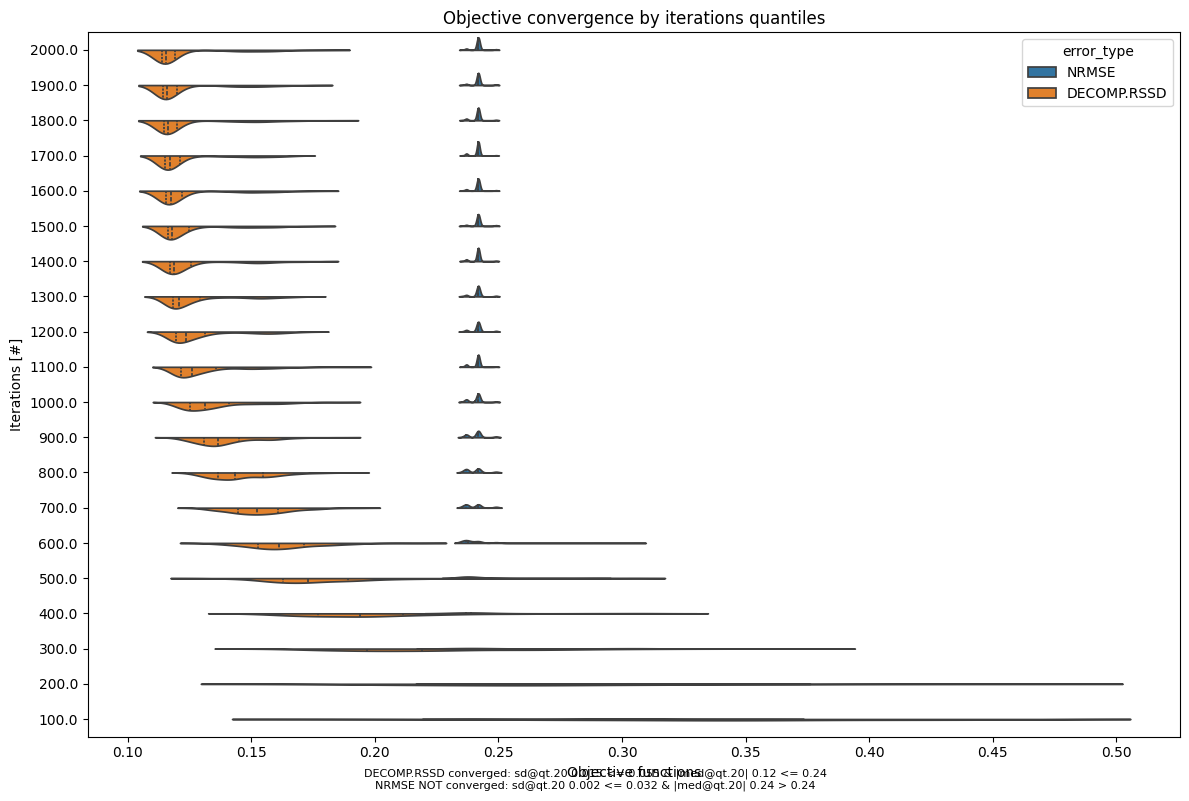

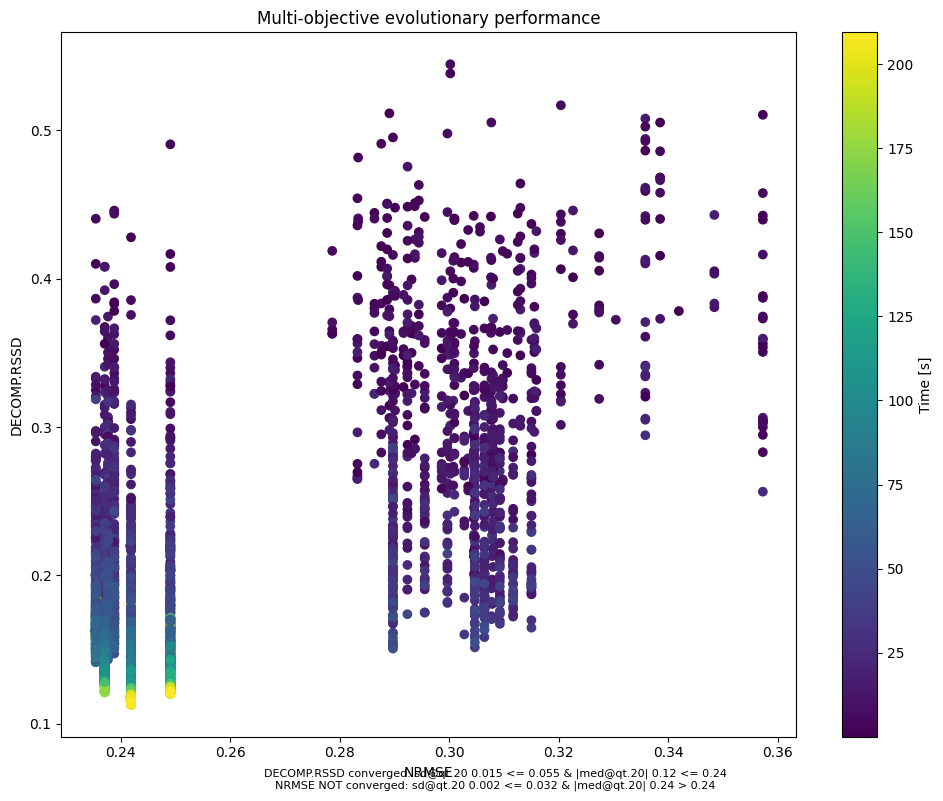

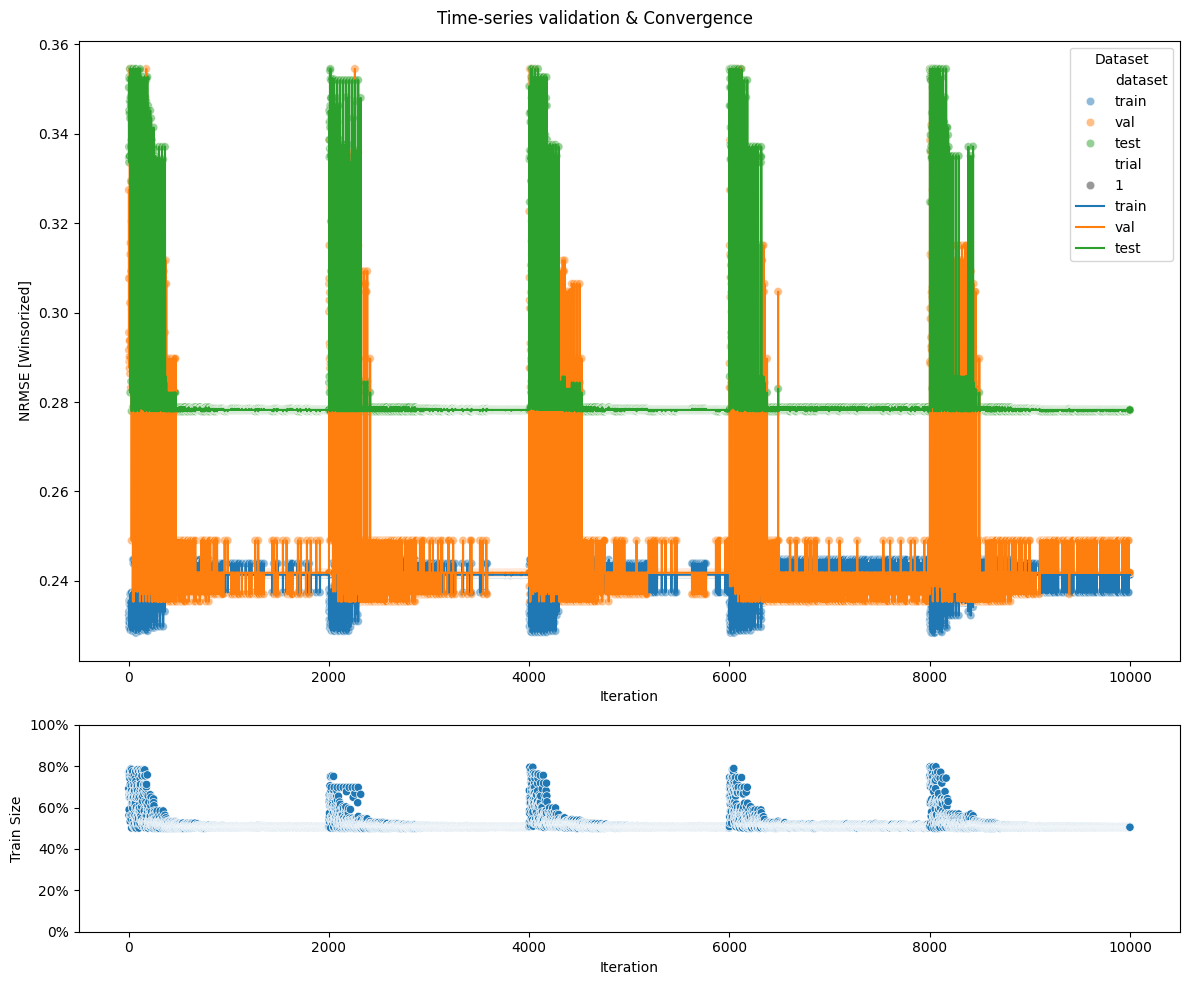

In [9]:
# Setup ModelExecutor
model_executor = ModelExecutor(
    mmmdata=mmm_data,
    holidays_data=holidays_data,
    hyperparameters=hyperparameters,
    calibration_input=None,  # Add calibration input if available
    featurized_mmm_data=featurized_mmm_data,
)

# Setup TrialsConfig
trials_config = TrialsConfig(iterations=2000, trials=5)  # Set to the number of cores you want to use

print(
    f">>> Starting {trials_config.trials} trials with {trials_config.iterations} iterations each using {NevergradAlgorithm.TWO_POINTS_DE.value} nevergrad algorithm on..."
)

# Run the model

output_models = model_executor.model_run(
    trials_config=trials_config,
    ts_validation=True,  # changed from True to False -> deacitvate
    add_penalty_factor=False,
    rssd_zero_penalty=True,
    cores=8,
    nevergrad_algo=NevergradAlgorithm.TWO_POINTS_DE,
    intercept=True,
    intercept_sign="non_negative",
    model_name=Models.RIDGE,
)
print("Model training complete.")

In [29]:
# import json
# import pandas as pd


# # Function to convert a DataFrame to a dictionary
# def dataframe_to_dict(df):
#     return df.to_dict(orient="list")


# # Function to convert a Trial object to a dictionary
# def trial_to_dict(trial):
#     return {
#         "result_hyp_param": dataframe_to_dict(trial.result_hyp_param),
#         "decomp_spend_dist": dataframe_to_dict(trial.decomp_spend_dist),
#         "x_decomp_agg": dataframe_to_dict(trial.x_decomp_agg),
#         "nrmse": trial.nrmse,
#         "decomp_rssd": trial.decomp_rssd,
#         "mape": trial.mape,
#         "rsq_train": trial.rsq_train,
#         "rsq_val": trial.rsq_val,
#         "rsq_test": trial.rsq_test,
#         "lambda_": trial.lambda_,
#         "lambda_hp": trial.lambda_hp,
#         "lambda_max": trial.lambda_max,
#         "lambda_min_ratio": trial.lambda_min_ratio,
#         "pos": trial.pos,
#         "nrmse_train": trial.nrmse_train,
#         "nrmse_val": trial.nrmse_val,
#         "nrmse_test": trial.nrmse_test,
#         "elapsed": trial.elapsed,
#         "elapsed_accum": trial.elapsed_accum,
#         "trial": trial.trial,
#         "iter_ng": trial.iter_ng,
#         "iter_par": trial.iter_par,
#         "train_size": trial.train_size,
#         "sol_id": trial.sol_id,
#         "lift_calibration": dataframe_to_dict(trial.lift_calibration),
#     }


# # Function to convert ModelOutputs to a dictionary
# def model_outputs_to_dict(model_outputs):
#     return {
#         "trials": [trial_to_dict(trial) for trial in model_outputs.trials],
#         "train_timestamp": model_outputs.train_timestamp,
#         "cores": model_outputs.cores,
#         "iterations": model_outputs.iterations,
#         "intercept": model_outputs.intercept,
#         "intercept_sign": model_outputs.intercept_sign,
#         "nevergrad_algo": str(model_outputs.nevergrad_algo),  # Convert to string or another serializable format
#         "ts_validation": model_outputs.ts_validation,
#         "add_penalty_factor": model_outputs.add_penalty_factor,
#         "hyper_updated": model_outputs.hyper_updated,
#         "hyper_fixed": model_outputs.hyper_fixed,
#         "select_id": model_outputs.select_id,
#         "hyper_bound_ng": model_outputs.hyper_bound_ng,
#         "hyper_bound_fixed": model_outputs.hyper_bound_fixed,
#         "seed": model_outputs.seed,
#         "convergence": model_outputs.convergence,
#         "ts_validation_plot": model_outputs.ts_validation_plot,
#         "all_result_hyp_param": dataframe_to_dict(model_outputs.all_result_hyp_param),
#         "all_x_decomp_agg": dataframe_to_dict(model_outputs.all_x_decomp_agg),
#         "all_decomp_spend_dist": dataframe_to_dict(model_outputs.all_decomp_spend_dist),
#     }


# # Assuming `output_models` is an instance of ModelOutputs
# def export_to_json(data, file_path):
#     # Convert the ModelOutputs object to a dictionary
#     data_dict = model_outputs_to_dict(data)

#     # Write the data to a JSON file
#     with open(file_path, "w") as json_file:
#         json.dump(data_dict, json_file, indent=4)


# # Call the export function
# export_to_json(
#     output_models, "/Users/yijuilee/robynpy_release_reviews/Robyn/python/src/tutorials/data/calculated_model_data.json"
# )
# print("Data exported successfully to exported_model_data.json")

TypeError: Object of type DataFrame is not JSON serializable

In [ ]:
stophere=

In [56]:
best_model_id = output_models.select_id
print(f"Best model ID: {best_model_id}")

Best model ID: 2_1_1


In [57]:
# Add after model training
print("Model Output Summary:")
print(f"Number of trials: {len(output_models.trials)}")
print(f"Average models per trial: {len(output_models.all_result_hyp_param) / len(output_models.trials)}")
print(f"Total unique models: {len(output_models.all_result_hyp_param['sol_id'].unique())}")

print("\nMetrics Distribution:")
metrics_df = output_models.all_result_hyp_param[["nrmse", "decomp.rssd", "mape"]]
print(metrics_df.describe())

# Additional validation to debug model output
print("\nColumns in result_hyp_param:")
print(output_models.all_result_hyp_param.columns.tolist())

print("\nSample rows of metrics:")
print(output_models.all_result_hyp_param[["sol_id", "nrmse", "decomp.rssd", "mape"]].head())

# Show shape of result dataframes
print("\nDataFrame Shapes:")
print(f"result_hyp_param: {output_models.all_result_hyp_param.shape}")
print(f"x_decomp_agg: {output_models.all_x_decomp_agg.shape}")
print(f"decomp_spend_dist: {output_models.all_decomp_spend_dist.shape}")

Model Output Summary:
Number of trials: 5
Average models per trial: 2000.0
Total unique models: 10000

Metrics Distribution:
              nrmse   decomp.rssd     mape
count  10000.000000  10000.000000  10000.0
mean       0.247854      0.160842      0.0
std        0.020856      0.063950      0.0
min        0.235213      0.112818      0.0
25%        0.238788      0.118582      0.0
50%        0.241848      0.139518      0.0
75%        0.241848      0.169268      0.0
max        0.419955      0.544516      0.0

Columns in result_hyp_param:
['facebook_S_thetas', 'facebook_S_alphas', 'facebook_S_gammas', 'print_S_thetas', 'print_S_alphas', 'print_S_gammas', 'tv_S_thetas', 'tv_S_alphas', 'tv_S_gammas', 'search_S_thetas', 'search_S_alphas', 'search_S_gammas', 'ooh_S_thetas', 'ooh_S_alphas', 'ooh_S_gammas', 'newsletter_thetas', 'newsletter_alphas', 'newsletter_gammas', 'lambda', 'train_size', 'sol_id', 'Elapsed', 'ElapsedAccum', 'pos', 'trial', 'rsq_train', 'rsq_val', 'rsq_test', 'nrmse', 'nrms

2024-11-14 17:06:04,677 - robyn.visualization.model_convergence_visualizer - INFO - Initialized ModelConvergenceVisualizer


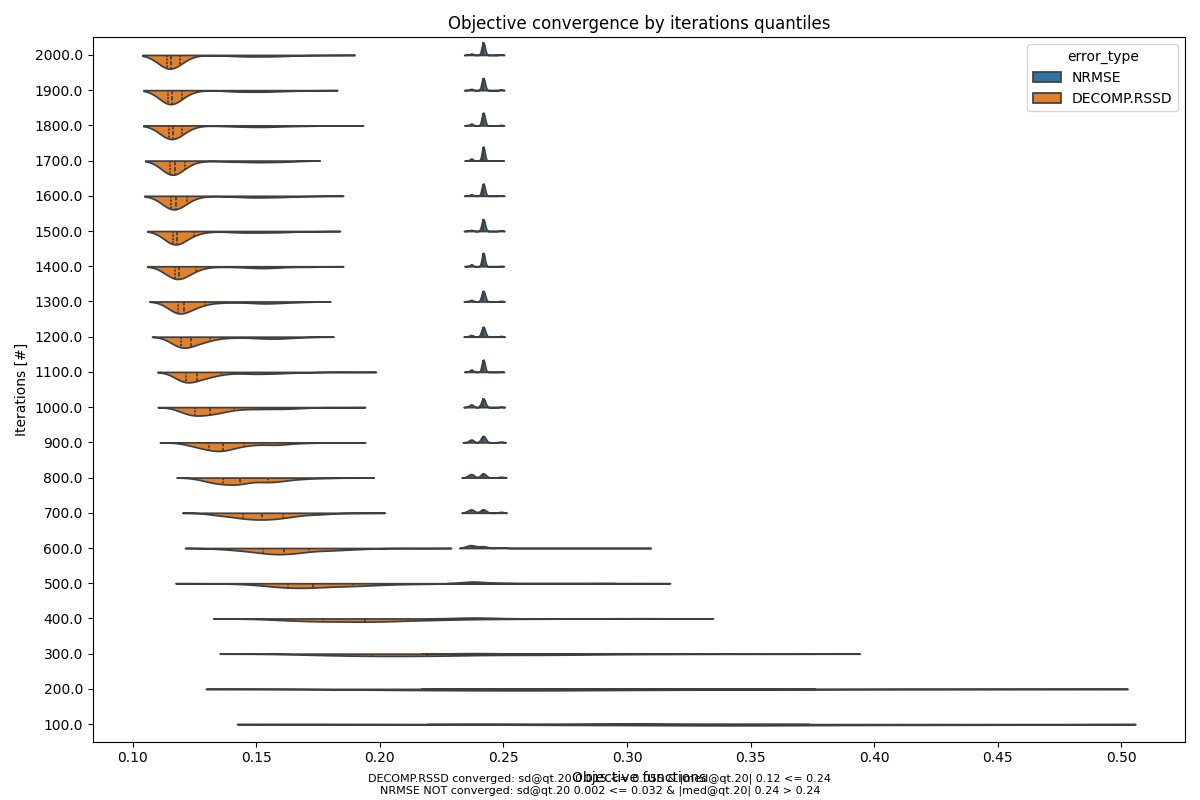

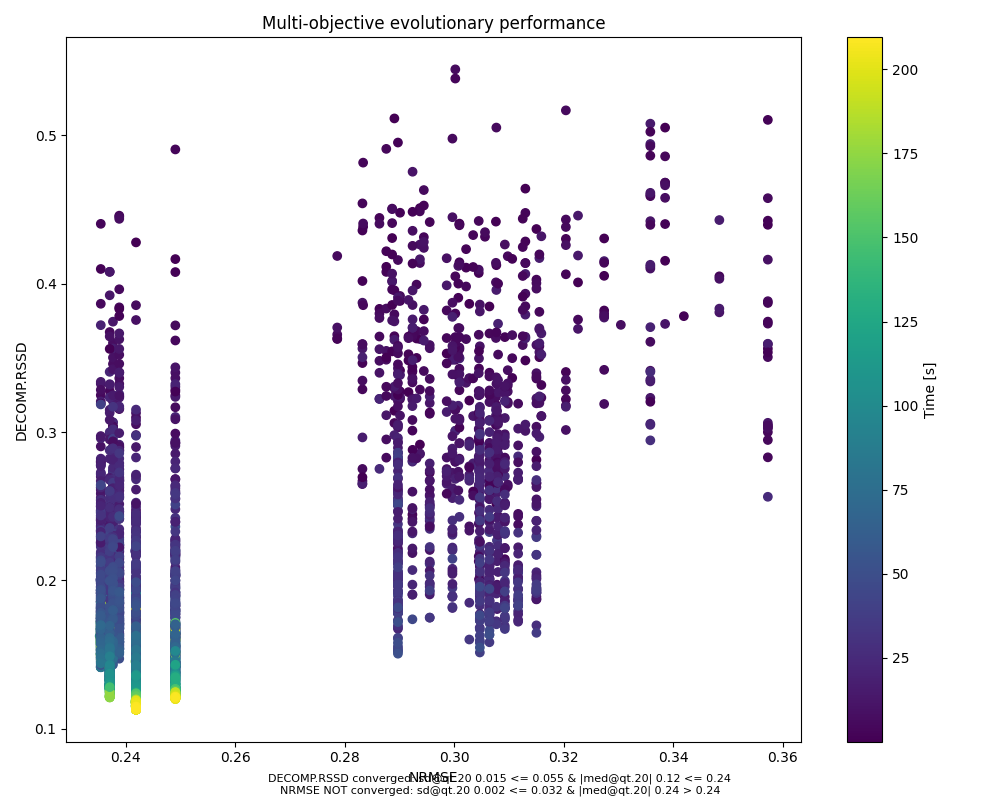

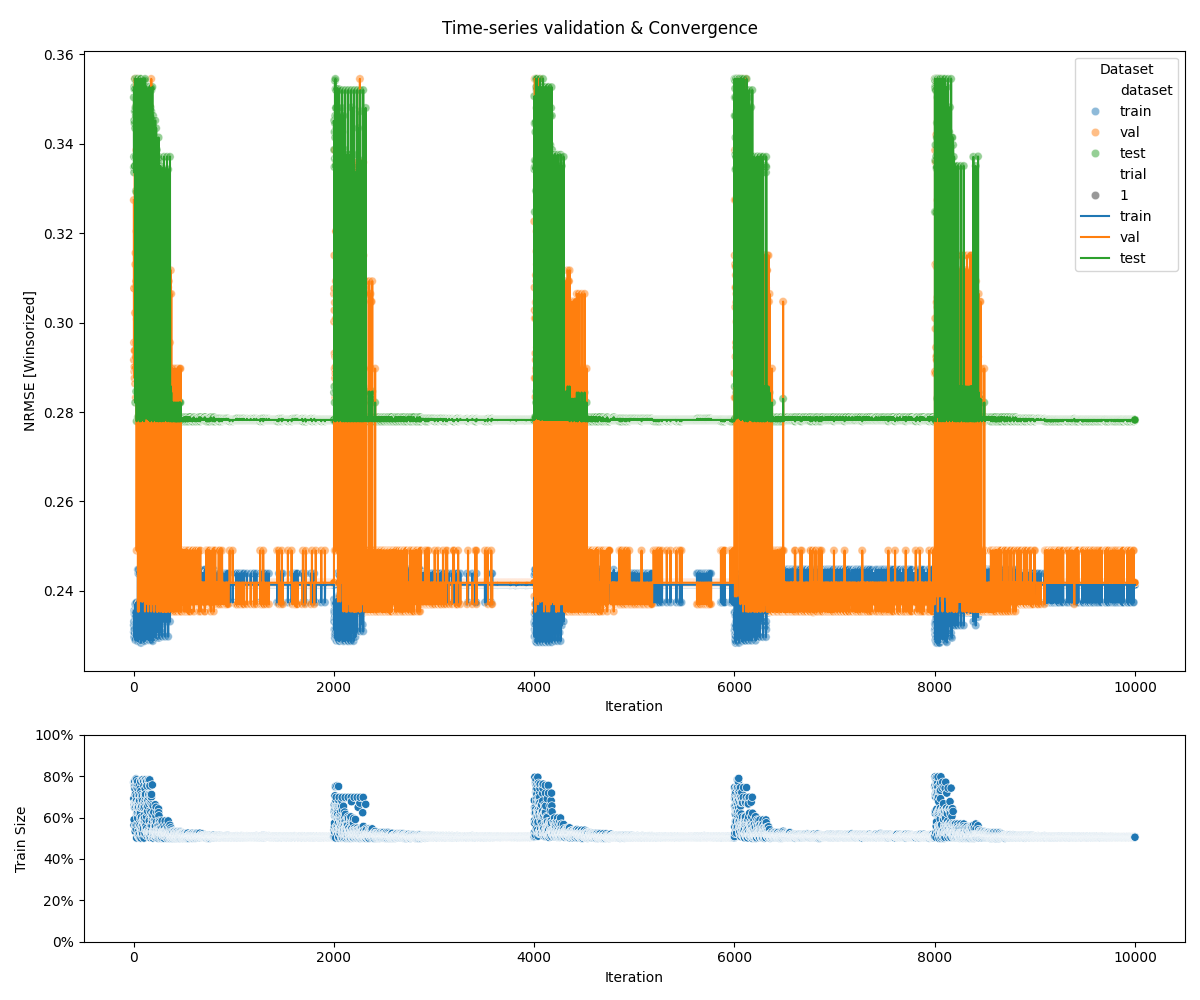

In [58]:
from IPython.display import Image, display
import base64
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from robyn.visualization.model_convergence_visualizer import ModelConvergenceVisualizer

model_visualizer = ModelConvergenceVisualizer(
    moo_distrb_plot=output_models.convergence["moo_distrb_plot"],
    ts_validation_plot=output_models.convergence["ts_validation_plot"],
    moo_cloud_plot=output_models.convergence["moo_cloud_plot"],
)

# 1. Display the MOO Distribution Plot
if "moo_distrb_plot" in output_models.convergence:
    model_visualizer.display_moo_distrb_plot()

# 2. Display the MOO Cloud Plot
if "moo_cloud_plot" in output_models.convergence:
    model_visualizer.display_moo_cloud_plot()

# 3. Display time series validation and convergence plots
if "ts_validation_plot" in output_models.convergence:
    model_visualizer.display_ts_validation_plot()

In [59]:
from robyn.modeling.pareto.pareto_optimizer import ParetoOptimizer
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
# 3. Create ParetoOptimizer instance
pareto_optimizer = ParetoOptimizer(mmm_data, output_models, hyperparameters, featurized_mmm_data, holidays_data)

In [61]:
# 4. Run optimize function
pareto_result = pareto_optimizer.optimize(pareto_fronts="auto", min_candidates=100)

2024-11-14 17:06:04 [INFO] Starting Pareto optimization


2024-11-14 17:06:04 [INFO] Starting model data aggregation
2024-11-14 17:06:04 [INFO] Computing Pareto fronts
2024-11-14 17:06:05 [INFO] Pareto front computation completed
2024-11-14 17:06:05 [INFO] Preparing Pareto data
2024-11-14 17:06:05 [INFO] Number of Pareto-optimal solutions found: 8642
2024-11-14 17:06:05 [INFO] Selected 4 Pareto-fronts containing 121 candidates
2024-11-14 17:06:05 [INFO] Filtering data for selected Pareto fronts...
2024-11-14 17:06:05 [INFO] Calculating response curves for 605 models' media variables...
Processing rows: 100%|██████████| 605/605 [00:31<00:00, 18.93it/s]
2024-11-14 17:06:38 [INFO] Successfully processed 605 response curves
2024-11-14 17:06:38 [INFO] Computing final metrics...
2024-11-14 17:06:38 [INFO] Calculating ROI and CPA metrics...
2024-11-14 17:06:38 [INFO] Starting plot data generation...
2024-11-14 17:06:38 [INFO] Processing Pareto front 1
2024-11-14 17:06:38 [INFO] Pareto-Front: 1 [26 models]
Processing Solutions:   8%|▊         | 2/26 

Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values


Processing Solutions:  19%|█▉        | 5/26 [00:00<00:02,  8.59solution/s]2024-11-14 17:06:39 [INFO] Calculating saturated dataframes with carryover and immediate parts


Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values


Processing Solutions:  31%|███       | 8/26 [00:00<00:02,  8.43solution/s]2024-11-14 17:06:39 [INFO] Calculating saturated dataframes with carryover and immediate parts


Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values


Processing Solutions:  42%|████▏     | 11/26 [00:01<00:01,  8.53solution/s]2024-11-14 17:06:40 [INFO] Calculating saturated dataframes with carryover and immediate parts


Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values


Processing Solutions:  54%|█████▍    | 14/26 [00:01<00:01,  8.51solution/s]2024-11-14 17:06:40 [INFO] Calculating saturated dataframes with carryover and immediate parts


Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values


Processing Solutions:  65%|██████▌   | 17/26 [00:01<00:01,  8.59solution/s]2024-11-14 17:06:40 [INFO] Calculating saturated dataframes with carryover and immediate parts


Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values


Processing Solutions:  77%|███████▋  | 20/26 [00:02<00:00,  8.59solution/s]2024-11-14 17:06:41 [INFO] Calculating saturated dataframes with carryover and immediate parts


Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values


Processing Solutions:  88%|████████▊ | 23/26 [00:02<00:00,  8.50solution/s]2024-11-14 17:06:41 [INFO] Calculating saturated dataframes with carryover and immediate parts


Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values


Processing Solutions: 100%|██████████| 26/26 [00:03<00:00,  8.50solution/s]
2024-11-14 17:06:41 [INFO] Processing Pareto front 2
2024-11-14 17:06:41 [INFO] Pareto-Front: 2 [31 models]


Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values


Processing Solutions:   0%|          | 0/31 [00:00<?, ?solution/s]2024-11-14 17:06:41 [INFO] Calculating saturated dataframes with carryover and immediate parts


Rolling window start which:  0
Rolling window end which:  None
Set default values


Processing Solutions:   6%|▋         | 2/31 [00:00<00:03,  8.51solution/s]2024-11-14 17:06:42 [INFO] Calculating saturated dataframes with carryover and immediate parts


Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values


Processing Solutions:  16%|█▌        | 5/31 [00:00<00:03,  7.33solution/s]

Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values


2024-11-14 17:06:42 [INFO] Calculating saturated dataframes with carryover and immediate parts
Processing Solutions:  23%|██▎       | 7/31 [00:00<00:03,  7.99solution/s]

Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values


2024-11-14 17:06:42 [INFO] Calculating saturated dataframes with carryover and immediate parts
Processing Solutions:  29%|██▉       | 9/31 [00:01<00:03,  6.28solution/s]2024-11-14 17:06:43 [INFO] Calculating saturated dataframes with carryover and immediate parts


Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values


Processing Solutions:  39%|███▊      | 12/31 [00:01<00:02,  7.41solution/s]2024-11-14 17:06:43 [INFO] Calculating saturated dataframes with carryover and immediate parts


Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values


Processing Solutions:  48%|████▊     | 15/31 [00:02<00:01,  8.04solution/s]2024-11-14 17:06:44 [INFO] Calculating saturated dataframes with carryover and immediate parts


Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values


Processing Solutions:  58%|█████▊    | 18/31 [00:02<00:01,  8.38solution/s]2024-11-14 17:06:44 [INFO] Calculating saturated dataframes with carryover and immediate parts


Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values


Processing Solutions:  68%|██████▊   | 21/31 [00:02<00:01,  8.38solution/s]2024-11-14 17:06:44 [INFO] Calculating saturated dataframes with carryover and immediate parts


Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values


Processing Solutions:  77%|███████▋  | 24/31 [00:03<00:00,  8.11solution/s]

Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values


2024-11-14 17:06:45 [INFO] Calculating saturated dataframes with carryover and immediate parts
Processing Solutions:  84%|████████▍ | 26/31 [00:03<00:00,  8.21solution/s]2024-11-14 17:06:45 [INFO] Calculating saturated dataframes with carryover and immediate parts


Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values


Processing Solutions:  94%|█████████▎| 29/31 [00:03<00:00,  8.43solution/s]2024-11-14 17:06:45 [INFO] Calculating saturated dataframes with carryover and immediate parts


Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values


Processing Solutions: 100%|██████████| 31/31 [00:03<00:00,  7.87solution/s]
2024-11-14 17:06:45 [INFO] Processing Pareto front 3
2024-11-14 17:06:45 [INFO] Pareto-Front: 3 [30 models]


Rolling window start which:  0
Rolling window end which:  None
Set default values


Processing Solutions:   3%|▎         | 1/30 [00:00<00:03,  8.45solution/s]

Rolling window start which:  0
Rolling window end which:  None
Set default values


2024-11-14 17:06:46 [INFO] Calculating saturated dataframes with carryover and immediate parts
Processing Solutions:   7%|▋         | 2/30 [00:00<00:03,  8.51solution/s]2024-11-14 17:06:46 [INFO] Calculating saturated dataframes with carryover and immediate parts


Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values


Processing Solutions:  10%|█         | 3/30 [00:00<00:03,  8.49solution/s]2024-11-14 17:06:46 [INFO] Calculating saturated dataframes with carryover and immediate parts


Rolling window start which:  0
Rolling window end which:  None
Set default values


Processing Solutions:  17%|█▋        | 5/30 [00:00<00:02,  8.40solution/s]2024-11-14 17:06:46 [INFO] Calculating saturated dataframes with carryover and immediate parts


Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values


Processing Solutions:  20%|██        | 6/30 [00:00<00:02,  8.44solution/s]2024-11-14 17:06:46 [INFO] Calculating saturated dataframes with carryover and immediate parts


Rolling window start which:  0
Rolling window end which:  None
Set default values


Processing Solutions:  27%|██▋       | 8/30 [00:00<00:02,  8.49solution/s]2024-11-14 17:06:46 [INFO] Calculating saturated dataframes with carryover and immediate parts


Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values


Processing Solutions:  37%|███▋      | 11/30 [00:01<00:02,  8.52solution/s]2024-11-14 17:06:47 [INFO] Calculating saturated dataframes with carryover and immediate parts


Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values


Processing Solutions:  47%|████▋     | 14/30 [00:01<00:01,  8.54solution/s]

Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values


2024-11-14 17:06:47 [INFO] Calculating saturated dataframes with carryover and immediate parts
Processing Solutions:  53%|█████▎    | 16/30 [00:01<00:01,  8.50solution/s]2024-11-14 17:06:47 [INFO] Calculating saturated dataframes with carryover and immediate parts


Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values


Processing Solutions:  63%|██████▎   | 19/30 [00:02<00:01,  8.51solution/s]2024-11-14 17:06:48 [INFO] Calculating saturated dataframes with carryover and immediate parts


Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values


Processing Solutions:  73%|███████▎  | 22/30 [00:02<00:00,  8.47solution/s]2024-11-14 17:06:48 [INFO] Calculating saturated dataframes with carryover and immediate parts


Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values


Processing Solutions:  83%|████████▎ | 25/30 [00:02<00:00,  8.49solution/s]2024-11-14 17:06:48 [INFO] Calculating saturated dataframes with carryover and immediate parts


Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values


Processing Solutions:  93%|█████████▎| 28/30 [00:03<00:00,  8.52solution/s]2024-11-14 17:06:49 [INFO] Calculating saturated dataframes with carryover and immediate parts


Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values


Processing Solutions: 100%|██████████| 30/30 [00:03<00:00,  8.49solution/s]
2024-11-14 17:06:49 [INFO] Processing Pareto front 4
2024-11-14 17:06:49 [INFO] Pareto-Front: 4 [34 models]


Rolling window start which:  0
Rolling window end which:  None
Set default values


Processing Solutions:   3%|▎         | 1/34 [00:00<00:03,  8.44solution/s]

Rolling window start which:  0
Rolling window end which:  None
Set default values


2024-11-14 17:06:49 [INFO] Calculating saturated dataframes with carryover and immediate parts
Processing Solutions:   6%|▌         | 2/34 [00:00<00:03,  8.34solution/s]2024-11-14 17:06:49 [INFO] Calculating saturated dataframes with carryover and immediate parts


Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values


Processing Solutions:  15%|█▍        | 5/34 [00:00<00:03,  8.44solution/s]2024-11-14 17:06:50 [INFO] Calculating saturated dataframes with carryover and immediate parts


Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values


Processing Solutions:  24%|██▎       | 8/34 [00:00<00:03,  8.39solution/s]2024-11-14 17:06:50 [INFO] Calculating saturated dataframes with carryover and immediate parts


Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values


Processing Solutions:  32%|███▏      | 11/34 [00:01<00:02,  8.48solution/s]2024-11-14 17:06:50 [INFO] Calculating saturated dataframes with carryover and immediate parts


Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values


Processing Solutions:  41%|████      | 14/34 [00:01<00:02,  8.46solution/s]

Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values


2024-11-14 17:06:51 [INFO] Calculating saturated dataframes with carryover and immediate parts
Processing Solutions:  47%|████▋     | 16/34 [00:01<00:02,  8.41solution/s]

Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values


2024-11-14 17:06:51 [INFO] Calculating saturated dataframes with carryover and immediate parts
Processing Solutions:  53%|█████▎    | 18/34 [00:02<00:01,  8.21solution/s]

Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values


2024-11-14 17:06:51 [INFO] Calculating saturated dataframes with carryover and immediate parts
Processing Solutions:  59%|█████▉    | 20/34 [00:02<00:01,  8.35solution/s]

Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values


2024-11-14 17:06:51 [INFO] Calculating saturated dataframes with carryover and immediate parts
Processing Solutions:  65%|██████▍   | 22/34 [00:02<00:01,  8.40solution/s]2024-11-14 17:06:52 [INFO] Calculating saturated dataframes with carryover and immediate parts


Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values


Processing Solutions:  74%|███████▎  | 25/34 [00:02<00:01,  8.30solution/s]2024-11-14 17:06:52 [INFO] Calculating saturated dataframes with carryover and immediate parts


Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values


Processing Solutions:  82%|████████▏ | 28/34 [00:03<00:00,  8.27solution/s]2024-11-14 17:06:52 [INFO] Calculating saturated dataframes with carryover and immediate parts


Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values


Processing Solutions:  91%|█████████ | 31/34 [00:03<00:00,  8.20solution/s]

Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values


2024-11-14 17:06:53 [INFO] Calculating saturated dataframes with carryover and immediate parts
Processing Solutions:  94%|█████████▍| 32/34 [00:03<00:00,  8.09solution/s]2024-11-14 17:06:53 [INFO] Calculating saturated dataframes with carryover and immediate parts


Rolling window start which:  0
Rolling window end which:  None
Set default values
Rolling window start which:  0
Rolling window end which:  None
Set default values


Processing Solutions: 100%|██████████| 34/34 [00:04<00:00,  8.14solution/s]
2024-11-14 17:06:53 [INFO] Pareto optimization completed successfully


Rolling window start which:  0
Rolling window end which:  None
Set default values


In [62]:
# 5. Check results
print("Pareto Optimization Results:")
print(f"Number of Pareto fronts: {pareto_result.pareto_solutions}")
print(f"MediaVecCollect: {pareto_result.media_vec_collect.shape, pareto_result.media_vec_collect}")
print("\Hyper parameter solutions:")
print(pareto_result.result_hyp_param)

print("\nAggregated decomposition results:")
print(pareto_result.x_decomp_agg)
print("\result Calibration:")
print(pareto_result.result_calibration)
print("\nx Decomp Vec Collect:")
print(pareto_result.x_decomp_vec_collect.shape, pareto_result.x_decomp_vec_collect)
print("\nCarryover percentage all:")
print(pareto_result.df_caov_pct_all.shape, pareto_result.df_caov_pct_all)
print("\Plot Data Collected")
print("NUMBER OF PLOTS Data collected for:", len(pareto_result.plot_data_collect))
print("Plot data for solid 5_221_9", pareto_result.plot_data_collect)

# 6. Validate logic
assert pareto_result.pareto_fronts == "auto" or isinstance(
    pareto_result.pareto_fronts, int
), "Invalid pareto_fronts value"
assert not pareto_result.result_hyp_param.empty, "Empty result_hyp_param DataFrame"
assert not pareto_result.x_decomp_agg.empty, "Empty x_decomp_agg DataFrame"

print("\nAll assertions passed. The optimize function is working as expected.")

Pareto Optimization Results:
Number of Pareto fronts: {'2_729_1', '2_661_1', '1_600_1', '3_1961_1', '3_1965_1', '2_765_1', '3_1864_1', '5_2000_1', '2_1763_1', '2_1634_1', '3_1084_1', '3_1683_1', '3_1986_1', '5_1960_1', '1_1688_1', '5_1857_1', '2_1382_1', '1_1634_1', '3_1998_1', '2_759_1', '5_1997_1', '1_1770_1', '4_685_1', '4_1350_1', '2_860_1', '5_1797_1', '1_1868_1', '1_360_1', '5_1980_1', '1_330_1', '2_710_1', '3_1745_1', '3_1752_1', '5_1944_1', '5_1991_1', '5_667_1', '4_716_1', '2_1225_1', '2_770_1', '4_1740_1', '2_1228_1', '2_1920_1', '5_445_1', '5_1059_1', '5_1827_1', '2_1231_1', '2_1967_1', '3_1709_1', '5_1965_1', '2_1937_1', '3_1886_1', '2_830_1', '3_1924_1', '5_1996_1', '1_1803_1', '4_1490_1', '2_768_1', '2_1330_1', '5_1950_1', '2_1907_1', '3_1632_1', '4_1550_1', '2_1877_1', '2_1539_1', '1_1266_1', '5_1971_1', '1_1296_1', '1_1808_1', '2_680_1', '3_1741_1', '2_1230_1', '3_1939_1', '3_1935_1', '4_1206_1', '4_495_1', '5_1975_1', '4_1471_1', '4_787_1', '2_326_1', '1_1168_1', '3_16

In [63]:
len(pareto_result.pareto_solutions)

121

## Allocator

In [64]:
## Step 1: Setup and Import

# Import necessary Robyn classes
from robyn.allocator.entities.enums import OptimizationScenario, ConstrMode
from robyn.allocator.budget_allocator import BudgetAllocator
from robyn.allocator.entities.allocation_config import AllocationConfig
from robyn.allocator.entities.allocation_constraints import AllocationConstraints
from robyn.visualization.allocator_plotter import AllocationPlotter
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
print(pareto_result.result_hyp_param["sol_id"])

0          1_1_1
1          1_2_1
2          1_3_1
3          1_4_1
4          1_5_1
          ...   
9995    5_1996_1
9996    5_1997_1
9997    5_1998_1
9998    5_1999_1
9999    5_2000_1
Name: sol_id, Length: 10000, dtype: object


In [66]:
# Make sure to use the correct model ID from your pareto results
available_models = pareto_result.result_hyp_param["sol_id"].unique()  # or 'solID' if that's the column name
print(f"Available models: {available_models}")
# Initialize allocator with a valid model ID
select_model = available_models[0]  # Use first available model

# Initialize budget allocator
allocator = BudgetAllocator(
    mmm_data=mmm_data,
    featurized_mmm_data=featurized_mmm_data,
    model_outputs=output_models,
    pareto_result=pareto_result,  # Get ParetoResult from import_output_collect()
    select_model=select_model,
)

2024-11-14 17:06:54,669 - robyn.allocator.budget_allocator - INFO - Initializing BudgetAllocator
2024-11-14 17:06:54,670 - robyn.allocator.media_response - INFO - Initializing MediaResponseParamsCalculator
2024-11-14 17:06:54,670 - robyn.allocator.allocation_optimizer - INFO - Initializing AllocationOptimizer
2024-11-14 17:06:54,671 - robyn.allocator.media_response - INFO - Starting media response parameters calculation for model 1_1_1
2024-11-14 17:06:54,723 - robyn.allocator.media_response - INFO - Successfully calculated media response parameters: MediaResponseParameters(alphas=5 channels, inflexions=5 channels, coefficients=5 channels)
2024-11-14 17:06:54,724 - robyn.allocator.budget_allocator - INFO - BudgetAllocator initialization completed successfully


Available models: ['1_1_1' '1_2_1' '1_3_1' ... '5_1998_1' '5_1999_1' '5_2000_1']


## Run Different Optimization Scenarios

### Scenario 1: Default Max Response

In [67]:
# Create base constraints matching R example
channel_constraints = AllocationConstraints(
    channel_constr_low={
        "tv_S": 0.7,  # -30% from base
        "ooh_S": 0.7,
        "print_S": 0.7,
        "facebook_S": 0.7,
        "search_S": 0.7,
    },
    channel_constr_up={
        "tv_S": 1.2,  # +20% from base
        "ooh_S": 1.5,  # +50% from base
        "print_S": 1.5,
        "facebook_S": 1.5,
        "search_S": 1.5,
    },
    channel_constr_multiplier=3.0,
)

# Configure max response scenario
max_response_config = AllocationConfig(
    scenario=OptimizationScenario.MAX_RESPONSE,
    constraints=channel_constraints,
    date_range="last",  # Use last period as initial
    total_budget=None,  # Use historical budget
    maxeval=100000,
    optim_algo="SLSQP_AUGLAG",
    constr_mode=ConstrMode.EQUALITY,
    plots=True,
)

# Run optimization
result = allocator.allocate(max_response_config)

# Print results
print(
    f"""
Model ID: {select_model}
Scenario: {max_response_config.scenario}
Use case: {result.metrics.get('use_case', '')}
Window: {result.metrics.get('date_range_start')}:{result.metrics.get('date_range_end')} ({result.metrics.get('n_periods')} {mmm_data.mmmdata_spec.interval_type})

Dep. Variable Type: {mmm_data.mmmdata_spec.dep_var_type}
Media Skipped: {result.metrics.get('skipped_channels', 'None')}
Relative Spend Increase: {result.metrics.get('spend_lift_pct', 0):.1f}% ({result.metrics.get('spend_lift_abs', 0):+.0f}K)
Total Response Increase (Optimized): {result.metrics.get('response_lift', 0)*100:.1f}%

Allocation Summary:
"""
)

# Print channel-level results
for channel in mmm_data.mmmdata_spec.paid_media_spends:
    current = result.optimal_allocations[result.optimal_allocations["channel"] == channel].iloc[0]

    print(
        f"""
- {channel}:
  Optimizable bound: [{(current['constr_low']-1)*100:.0f}%, {(current['constr_up']-1)*100:.0f}%],
  Initial spend share: {current['current_spend_share']*100:.2f}% -> Optimized bounded: {current['optimal_spend_share']*100:.2f}%
  Initial response share: {current['current_response_share']*100:.2f}% -> Optimized bounded: {current['optimal_response_share']*100:.2f}%
  Initial abs. mean spend: {current['current_spend']/1000:.3f}K -> Optimized: {current['optimal_spend']/1000:.3f}K [Delta = {(current['optimal_spend']/current['current_spend']-1)*100:.0f}%]
"""
    )

2024-11-14 17:06:54,755 - robyn.allocator.budget_allocator - INFO - Starting budget allocation optimization
2024-11-14 17:06:54,757 - robyn.allocator.budget_allocator - WARNING - Found zero mean spend for channels: ['tv_S' 'ooh_S' 'print_S' 'search_S']
2024-11-14 17:06:54,759 - robyn.allocator.response_calculator - INFO - Successfully calculated gradient value: -0.0000
2024-11-14 17:06:54,759 - robyn.allocator.response_calculator - INFO - Successfully calculated gradient value: -0.0000
2024-11-14 17:06:54,760 - robyn.allocator.response_calculator - INFO - Successfully calculated gradient value: -0.0000
2024-11-14 17:06:54,760 - robyn.allocator.response_calculator - INFO - Successfully calculated gradient value: -0.0000
2024-11-14 17:06:54,760 - robyn.allocator.response_calculator - INFO - Successfully calculated gradient value: -0.0000
2024-11-14 17:06:54,761 - robyn.allocator.budget_allocator - INFO - Initial metrics calculated successfully
2024-11-14 17:06:54,761 - robyn.allocator.bu


Model ID: 1_1_1
Scenario: max_response
Use case: 
Window: 2019-11-11 00:00:00:2019-11-11 00:00:00 (1 week)

Dep. Variable Type: revenue
Media Skipped: None
Relative Spend Increase: 0.0% (+0K)
Total Response Increase (Optimized): 0.0%

Allocation Summary:


- tv_S:
  Optimizable bound: [-30%, 20%],
  Initial spend share: 7.14% -> Optimized bounded: 7.14%
  Initial response share: 2.70% -> Optimized bounded: 2.70%
  Initial abs. mean spend: 1.221K -> Optimized: 1.221K [Delta = 0%]


- ooh_S:
  Optimizable bound: [-30%, 50%],
  Initial spend share: 7.14% -> Optimized bounded: 7.14%
  Initial response share: 0.20% -> Optimized bounded: 0.20%
  Initial abs. mean spend: 1.221K -> Optimized: 1.221K [Delta = 0%]


- print_S:
  Optimizable bound: [-30%, 50%],
  Initial spend share: 7.14% -> Optimized bounded: 7.14%
  Initial response share: 0.50% -> Optimized bounded: 0.50%
  Initial abs. mean spend: 1.221K -> Optimized: 1.221K [Delta = 0%]


- facebook_S:
  Optimizable bound: [-30%, 50%],
  I

### Scenario 3: Target Efficiency
Optimize allocation based on target ROI/CPA.

In [68]:
### Scenario 3: Default Target Efficiency (Target ROAS or CPA)
print("\nScenario 3: Target efficiency optimization")

# Create constraints matching R's implementation
default_channel_constraints = AllocationConstraints(
    channel_constr_low={
        channel: 0.1 for channel in mmm_data.mmmdata_spec.paid_media_spends  # -90% from base for all channels
    },
    channel_constr_up={
        channel: 10.0 for channel in mmm_data.mmmdata_spec.paid_media_spends  # +900% from base for all channels
    },
    channel_constr_multiplier=1.0,  # Don't extend bounds for target efficiency
    is_target_efficiency=True,  # Flag this as target efficiency scenario
)

# Create configuration for target efficiency scenario
target_efficiency_config = AllocationConfig(
    scenario=OptimizationScenario.TARGET_EFFICIENCY,
    constraints=default_channel_constraints,
    date_range="all",  # Use all dates like in R version
    target_value=None,  # Will use default 80% of initial ROAS or 120% of initial CPA
    maxeval=100000,
    optim_algo="SLSQP_AUGLAG",
    constr_mode=ConstrMode.EQUALITY,
    plots=True,
)

# Run optimization
result3 = allocator.allocate(target_efficiency_config)

# Print results matching R format
print(
    f"""
Model ID: {select_model}
Scenario: {target_efficiency_config.scenario}
Use case: {result3.metrics.get('use_case', '')}
Window: {result3.metrics.get('date_range_start')}:{result3.metrics.get('date_range_end')} ({result3.metrics.get('n_periods')} {mmm_data.mmmdata_spec.interval_type})

Dep. Variable Type: {mmm_data.mmmdata_spec.dep_var_type}
Media Skipped: {result3.metrics.get('skipped_channels', 'None')}
Relative Spend Increase: {result3.metrics.get('spend_lift_pct', 0):.0f}% ({result3.metrics.get('spend_lift_abs', 0):.0f})
Total Response Increase (Optimized): {result3.metrics.get('response_lift', 0)*100:.0f}%

Allocation Summary:
"""
)

# Print channel-level results
for channel in mmm_data.mmmdata_spec.paid_media_spends:
    current = result3.optimal_allocations[result3.optimal_allocations["channel"] == channel].iloc[0]

    print(
        f"""
- {channel}:
  Optimizable bound: [{(current['constr_low']-1)*100:.0f}%, {(current['constr_up']-1)*100:.0f}%],
  Initial spend share: {current['current_spend_share']*100:.2f}% -> Optimized bounded: {current['optimal_spend_share']*100:.2f}%
  Initial response share: {current['current_response_share']*100:.2f}% -> Optimized bounded: {current['optimal_response_share']*100:.2f}%
  Initial abs. mean spend: {current['current_spend']/1000:.3f}K -> Optimized: {current['optimal_spend']/1000:.3f}K [Delta = {(current['optimal_spend']/current['current_spend']-1)*100:.0f}%]
"""
    )

2024-11-14 17:06:54,820 - robyn.allocator.budget_allocator - INFO - Starting budget allocation optimization
2024-11-14 17:06:54,822 - robyn.allocator.response_calculator - INFO - Successfully calculated gradient value: -0.0000
2024-11-14 17:06:54,823 - robyn.allocator.response_calculator - INFO - Successfully calculated gradient value: -0.0000
2024-11-14 17:06:54,823 - robyn.allocator.response_calculator - INFO - Successfully calculated gradient value: -0.0000
2024-11-14 17:06:54,823 - robyn.allocator.response_calculator - INFO - Successfully calculated gradient value: -0.0000
2024-11-14 17:06:54,824 - robyn.allocator.response_calculator - INFO - Successfully calculated gradient value: -0.0000
2024-11-14 17:06:54,824 - robyn.allocator.budget_allocator - INFO - Initial metrics calculated successfully
2024-11-14 17:06:54,824 - robyn.allocator.budget_allocator - INFO - Running optimization for scenario: OptimizationScenario.TARGET_EFFICIENCY
2024-11-14 17:06:54,824 - robyn.allocator.budge


Scenario 3: Target efficiency optimization


2024-11-14 17:06:54,841 - robyn.allocator.budget_allocator - INFO - Response curves generated successfully
2024-11-14 17:06:54,855 - robyn.allocator.budget_allocator - INFO - Response curves generated successfully
2024-11-14 17:06:54,855 - robyn.allocator.budget_allocator - INFO - Budget allocation optimization completed successfully



Model ID: 1_1_1
Scenario: target_efficiency
Use case: all_historical_vec + historical_budget
Window: 2015-11-23 00:00:00:2019-11-11 00:00:00 (208 week)

Dep. Variable Type: revenue
Media Skipped: None
Relative Spend Increase: -3% (-2)
Total Response Increase (Optimized): -22%

Allocation Summary:


- tv_S:
  Optimizable bound: [-90%, 900%],
  Initial spend share: 21.25% -> Optimized bounded: 21.79%
  Initial response share: 33.75% -> Optimized bounded: 43.27%
  Initial abs. mean spend: 14.844K -> Optimized: 14.784K [Delta = -0%]


- ooh_S:
  Optimizable bound: [-90%, 900%],
  Initial spend share: 61.87% -> Optimized bounded: 63.88%
  Initial response share: 7.67% -> Optimized bounded: 9.90%
  Initial abs. mean spend: 43.218K -> Optimized: 43.342K [Delta = 0%]


- print_S:
  Optimizable bound: [-90%, 900%],
  Initial spend share: 5.34% -> Optimized bounded: 5.34%
  Initial response share: 4.86% -> Optimized bounded: 5.92%
  Initial abs. mean spend: 3.729K -> Optimized: 3.624K [Delta = 

2024-11-14 17:06:54,879 - robyn.visualization.base_visualizer - INFO - Initializing BaseVisualizer with style: bmh
2024-11-14 17:06:54,880 - robyn.visualization.base_visualizer - INFO - BaseVisualizer initialization completed
2024-11-14 17:06:54,880 - robyn.visualization.allocator_plotter - INFO - AllocationPlotter initialized successfully with result: AllocationResult(
Total Current Spend: $17,088.90
Total Optimal Spend: $17,088.90
Spend Lift: +0.0%
Response Lift: +0.0%)
2024-11-14 17:06:54,881 - robyn.visualization.base_visualizer - INFO - Initializing BaseVisualizer with style: bmh
2024-11-14 17:06:54,881 - robyn.visualization.base_visualizer - INFO - BaseVisualizer initialization completed
2024-11-14 17:06:54,882 - robyn.visualization.allocator_plotter - INFO - AllocationPlotter initialized successfully with result: AllocationResult(
Total Current Spend: $69,851.44
Total Optimal Spend: $67,847.08
Spend Lift: -2.9%
Response Lift: -22.3%)
2024-11-14 17:06:54,882 - robyn.visualization

Max Response Scenario Plots:
--------------------------------------------------


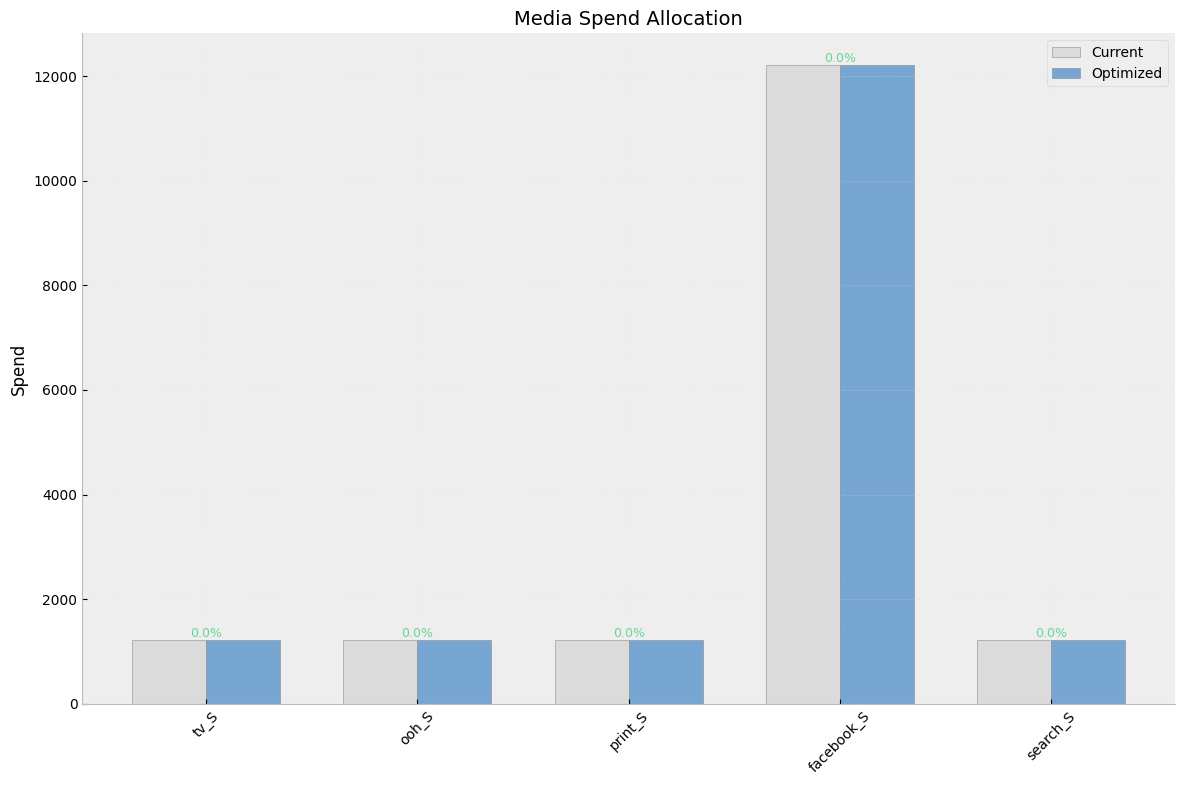

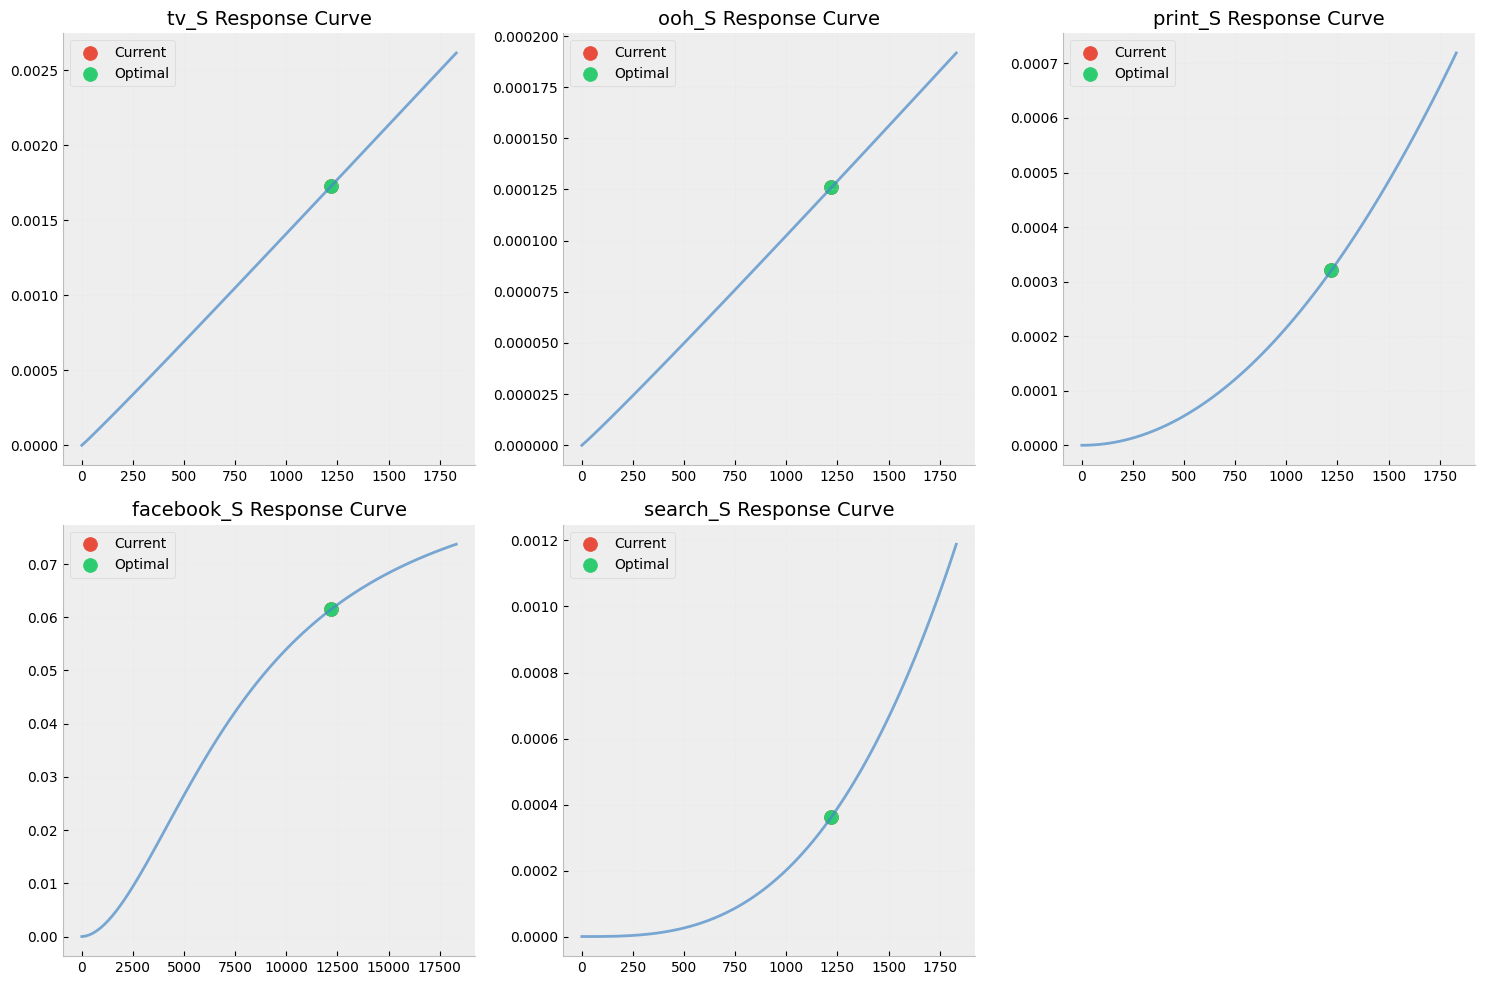

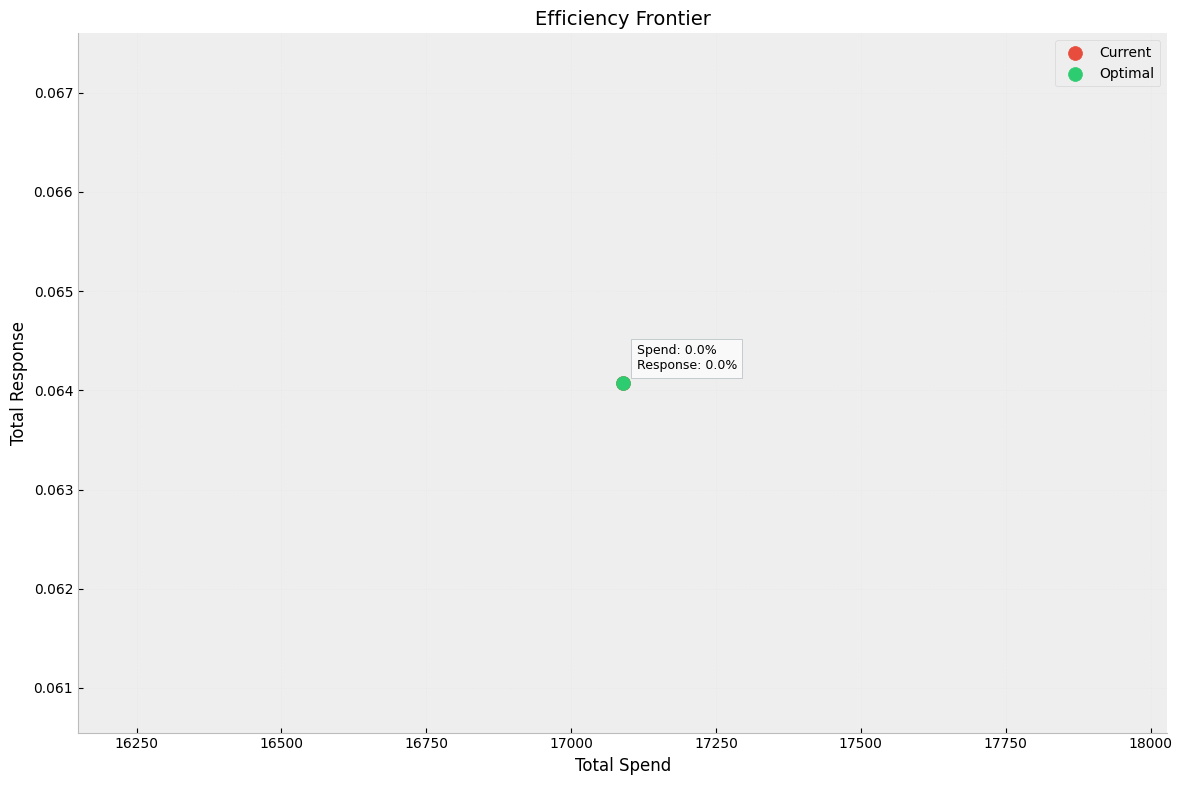

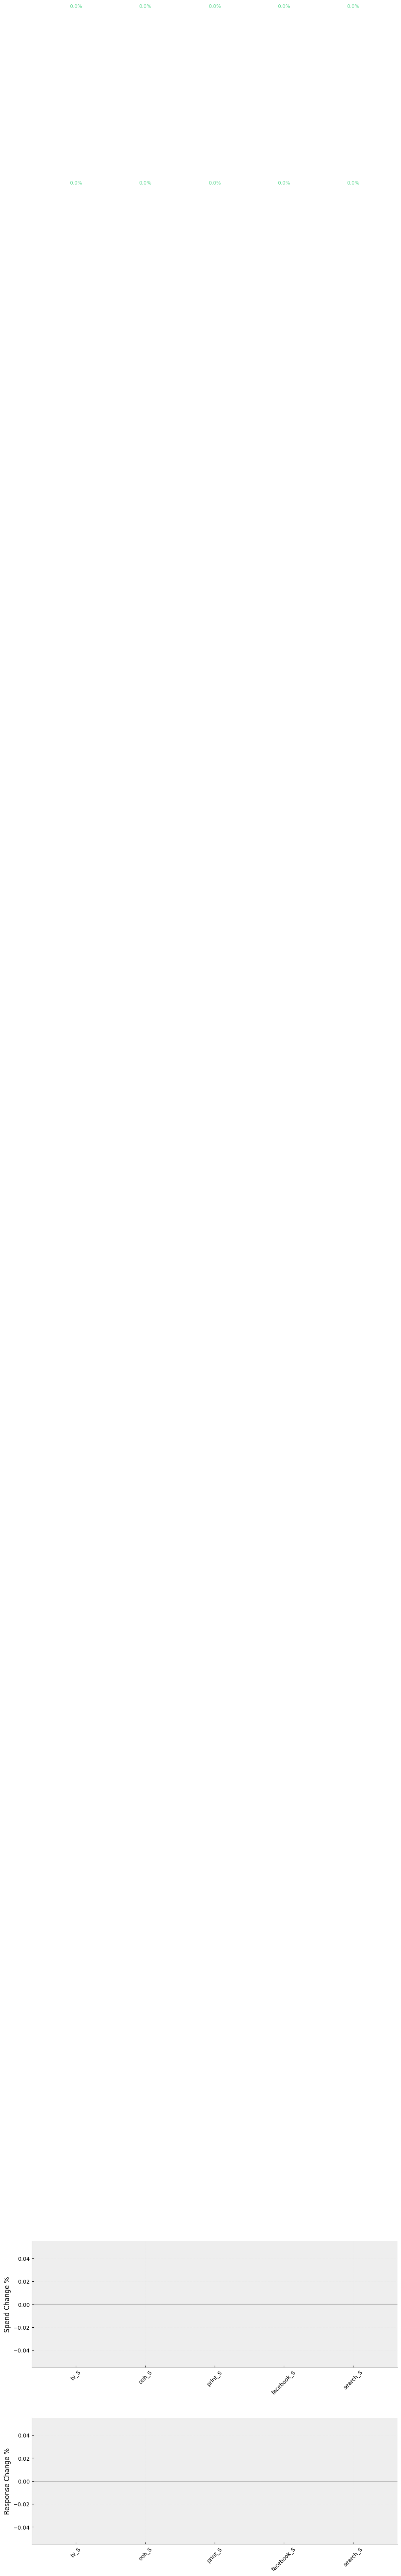

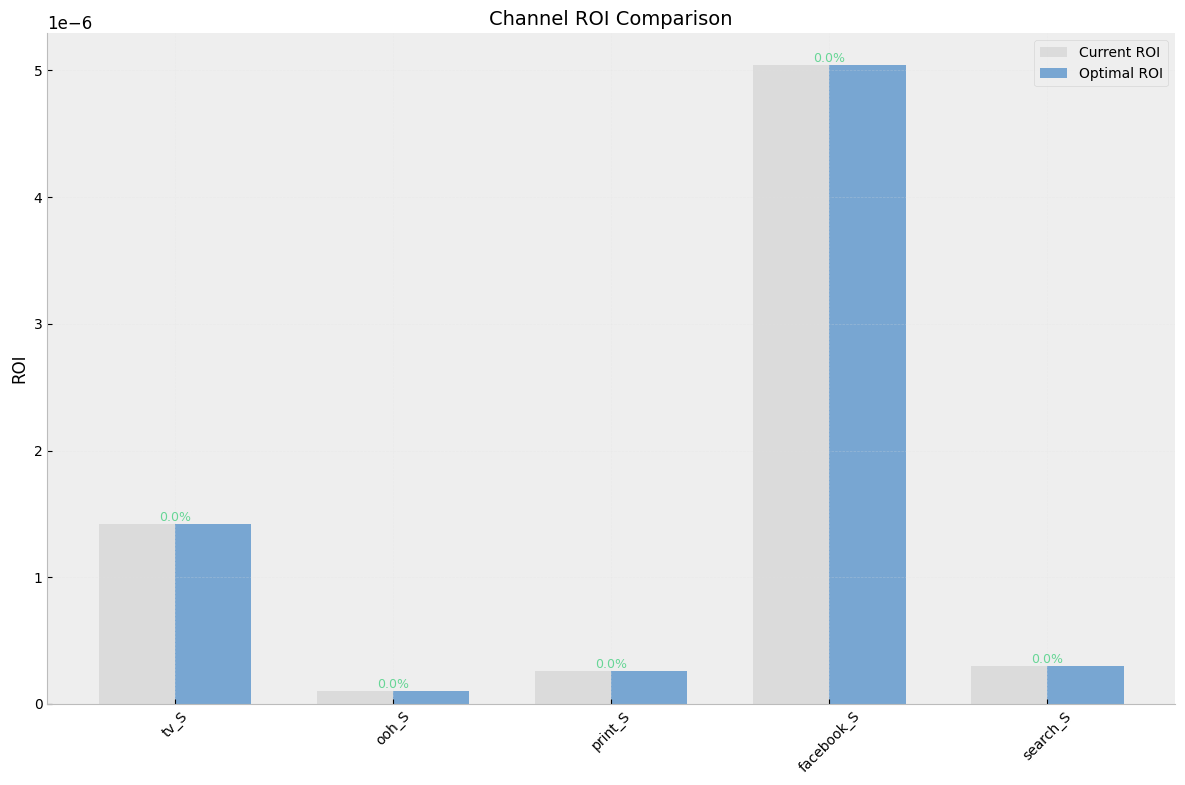


Target Efficiency Scenario Plots:
--------------------------------------------------


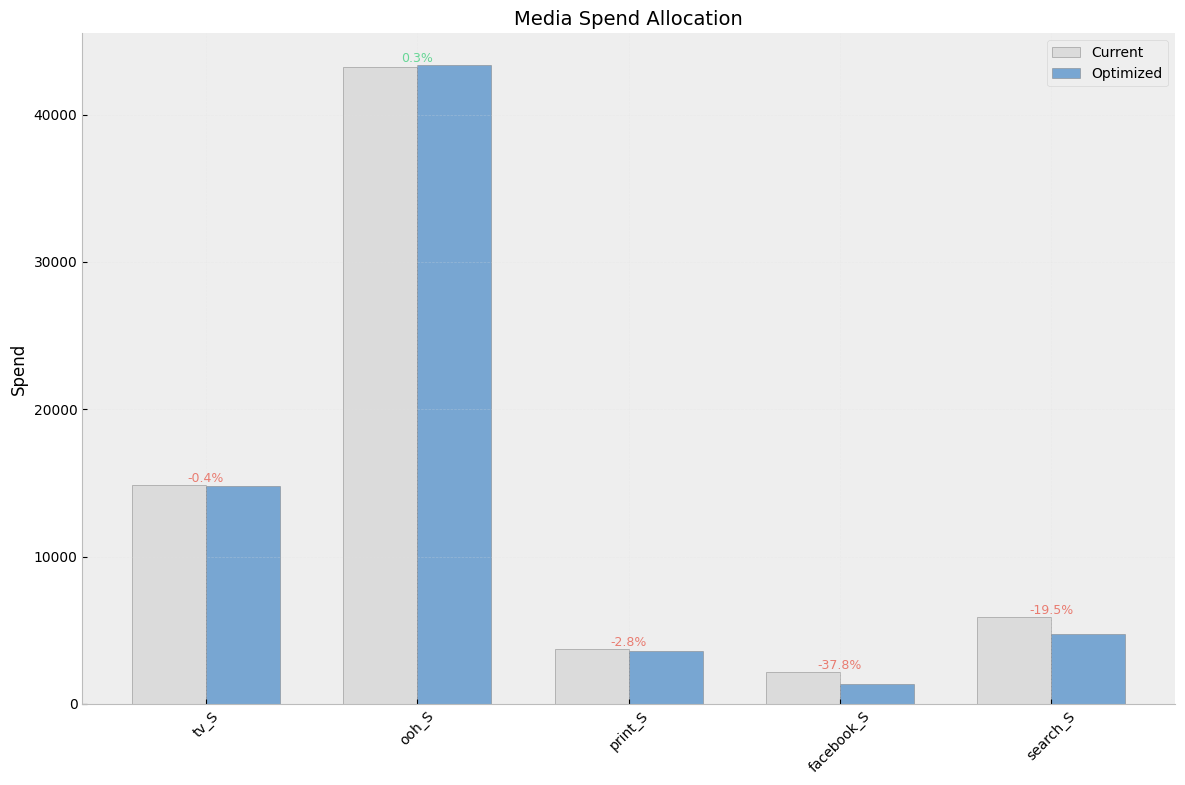

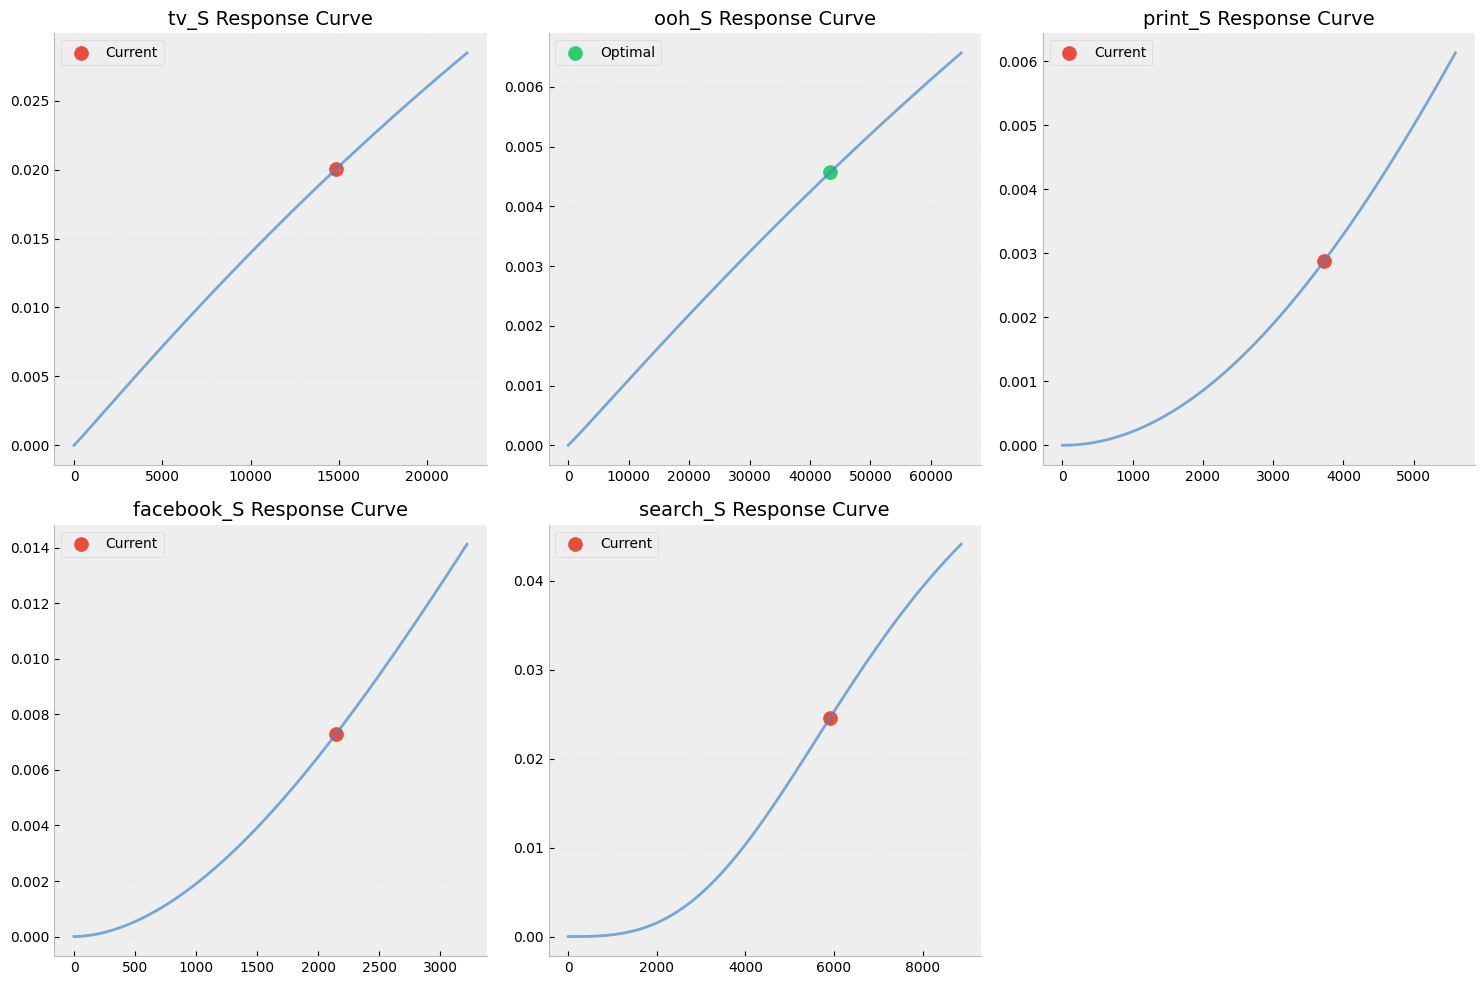

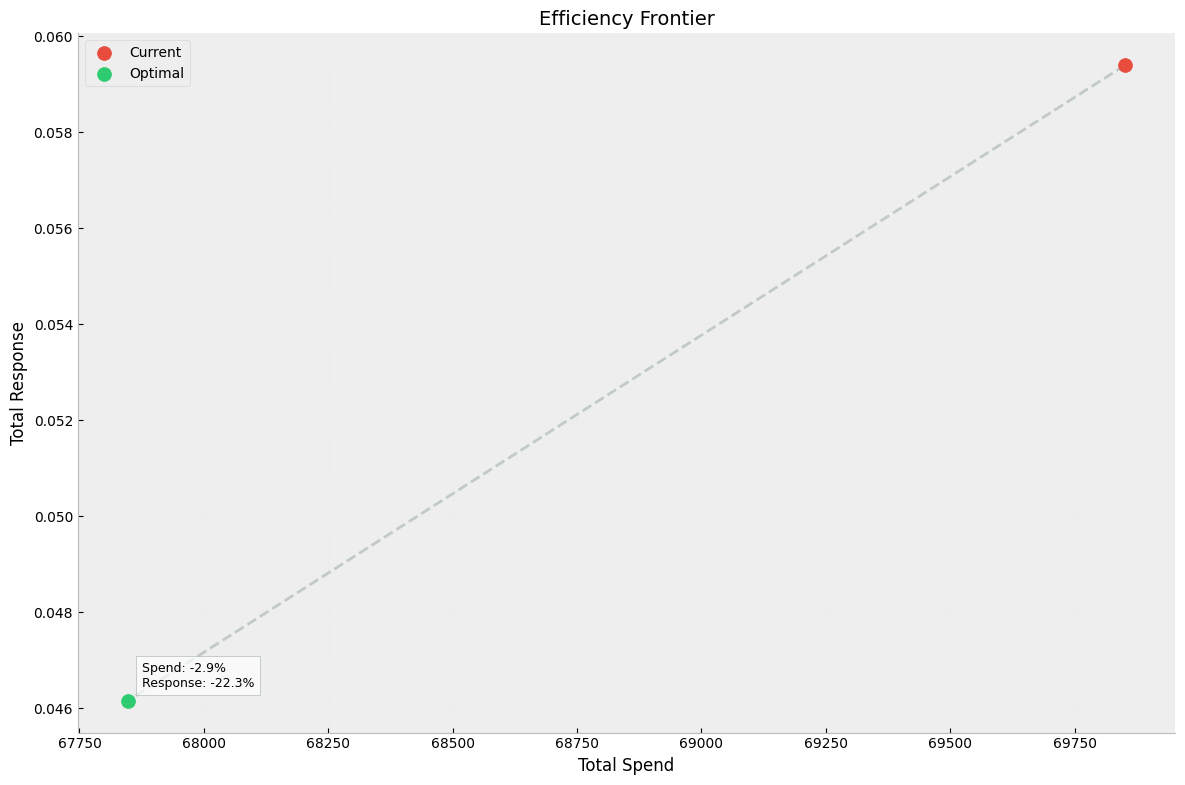

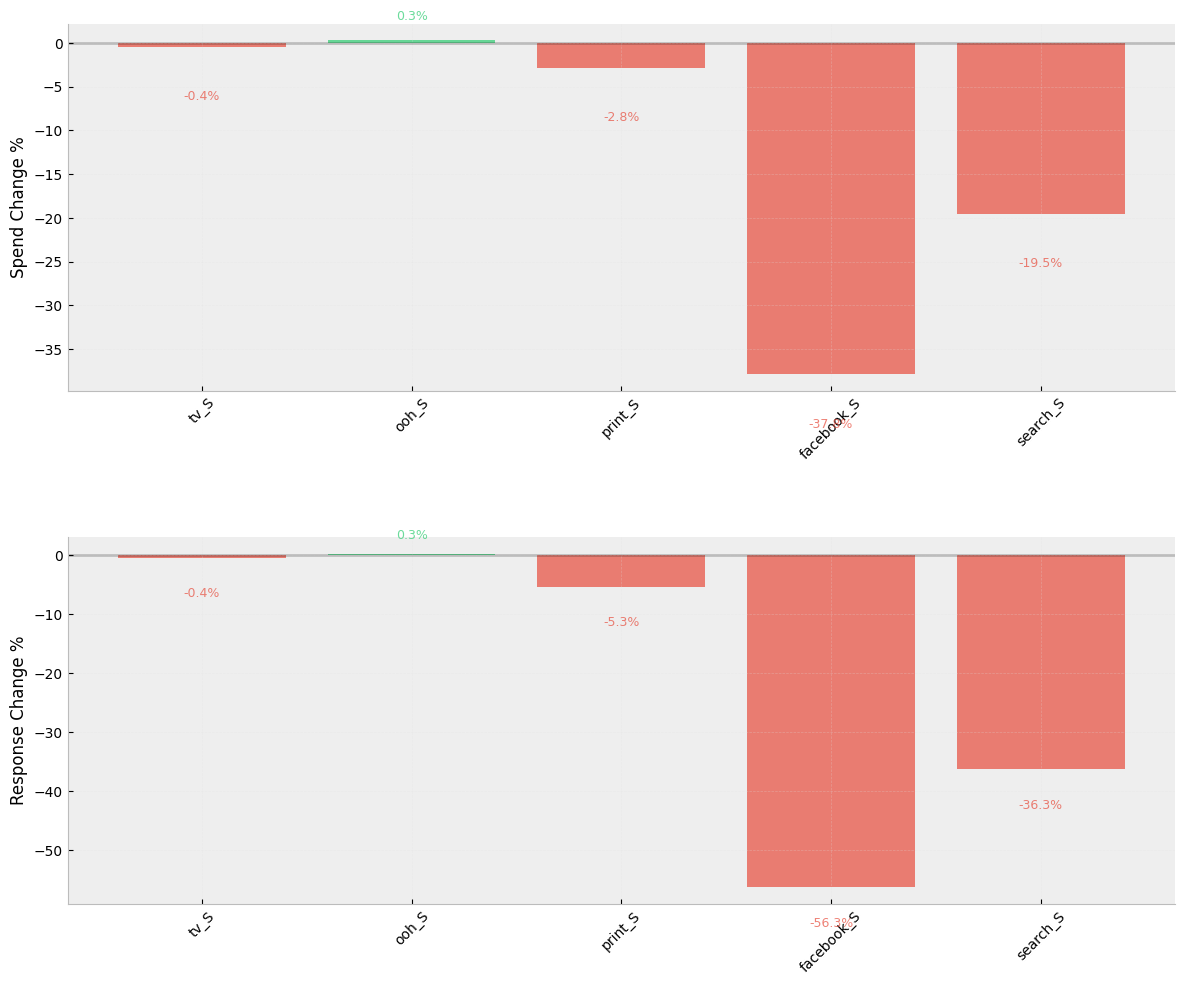

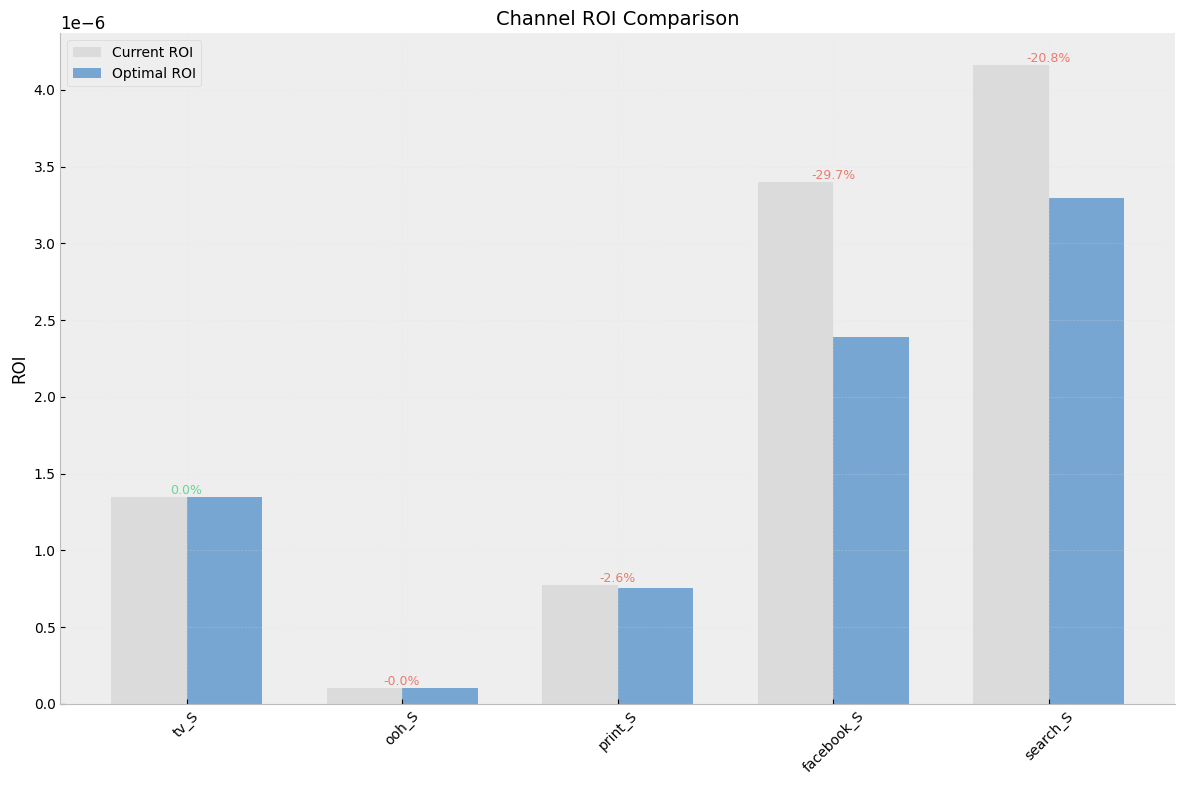

In [69]:
# Create visualizations for each scenario
max_response_plotter = AllocationPlotter(result)
target_efficiency_plotter = AllocationPlotter(result3)

# Generate plots
max_response_plots = max_response_plotter.plot_all()
target_efficiency_plots = target_efficiency_plotter.plot_all()

# Display plots
print("Max Response Scenario Plots:")
print("-" * 50)
for plot_name, fig in max_response_plots.items():
    display(fig)


print("\nTarget Efficiency Scenario Plots:")
print("-" * 50)
for plot_name, fig in target_efficiency_plots.items():
    display(fig)